## Question 2 – N-Gram Language Modeling with Moby-Dick

In [1]:
# imports
import requests
import re
import string
import random
import numpy as np
from collections import defaultdict, Counter
import heapq  # for beam search
import matplotlib.pyplot as plt

In [2]:
# Loading the Moby-Dick file I uploaded
with open('moby_dick.txt', 'r', encoding='utf-8') as file:
    moby_text = file.read()

print(f"A total of loaded charaters are {len(moby_text)}")
print("First bit of text:")
print(moby_text[:200])

A total of loaded charaters are 1279525
First bit of text:
CHAPTER 1
Loomings

Call me Ishmael. Some years ago--never mind how long precisely-having little or no money in my purse, and nothing particular
to interest me on shore, I thought I would sail about a


In [3]:
 #taking 10 consecutive chapters strting with num chap 10

lines = moby_text.split('\n')

start_chapter = 10  
num_chapters = 10    
end_chapter = start_chapter + num_chapters - 1

chapters_found = []
for i, line in enumerate(lines):
    if line.startswith('CHAPTER ') and len(line.split()) > 1:
        try:
            chapter_num = int(line.split()[1])
            if start_chapter <= chapter_num <= end_chapter:
                chapters_found.append((chapter_num, i, line.strip()))
        except:
            pass

print(f"Looking for chapters {start_chapter} to {end_chapter} ({num_chapters} total):")
print("Found these chapters:")
for num, line_idx, title in chapters_found:
    print(f"  {title}")
    
print(f"\n We will consider {len(chapters_found)} consecutive chapters")

Looking for chapters 10 to 19 (10 total):
Found these chapters:
  CHAPTER 10
  CHAPTER 11
  CHAPTER 12
  CHAPTER 13
  CHAPTER 14
  CHAPTER 15
  CHAPTER 16
  CHAPTER 17
  CHAPTER 18
  CHAPTER 19

 We will consider 10 consecutive chapters


In [4]:
start_line = chapters_found[0][1] 

end_line = None
for i, line in enumerate(lines[start_line + 1:], start_line + 1):
    if line.startswith('CHAPTER 40'):
        end_line = i
        break

if not end_line:
    end_line = chapters_found[-1][1] + 500  

# Extract the text
my_text = '\n'.join(lines[start_line:end_line])
print(f"Extracted {len(my_text)} characters from 10 chapters")
print("\nFirst 200 characters:")
print(my_text[:200])

Extracted 266195 characters from 10 chapters

First 200 characters:
CHAPTER 10
A Bosom Friend
Returning to the Spouter-Inn from the Chapel, I found Queequeg there
quite alone; he having left the Chapel before the benediction some time.
He was sitting on a bench before


In [5]:
# Remove chapter headers first
clean_text = re.sub(r'CHAPTER \d+.*?\n.*?\n', '', my_text)

# Convert to lowercase
clean_text = clean_text.lower()

# Remove punctuation and keep only letters and spaces
clean_text = re.sub(r'[^a-z\s]', '', clean_text)

# Fix multiple spaces
clean_text = re.sub(r'\s+', ' ', clean_text).strip()

# Split into words
words = clean_text.split()

print(f"After preprocessing: {len(words)} words")
print("First 15 words:", words[:15])
print("Last 15 words:", words[-15:])

After preprocessing: 44306 words
First 15 words: ['returning', 'to', 'the', 'spouterinn', 'from', 'the', 'chapel', 'i', 'found', 'queequeg', 'there', 'quite', 'alone', 'he', 'having']
Last 15 words: ['he', 'has', 'his', 'too', 'if', 'im', 'not', 'mistakenaye', 'aye', 'sir', 'just', 'through', 'with', 'this', 'jobcoming']


In [6]:
# Building the bigram model
bigram_counts = defaultdict(Counter)

for i in range(len(words) - 1):
    current_word = words[i]
    next_word = words[i + 1]
    bigram_counts[current_word][next_word] += 1

print(f"Built bigram model with {len(bigram_counts)} unique starting words")

if 'call' in bigram_counts:
    print(f"Words that follow 'call': {dict(bigram_counts['call'])}")
else:
    print("'call' not found in our text - let's check 'the' instead:")
    print(f"Top 5 words after 'the': {bigram_counts['the'].most_common(5)}")

Built bigram model with 7578 unique starting words
Words that follow 'call': {'a': 2, 'him': 4, 'that': 1, 'all': 1, 'of': 2, 'such': 1, 'it': 1, 'me': 1, 'upon': 1, 'our': 1, 'moby': 1}


In [7]:
# Greedy decoding - always pick the most common next word
def greedy_generate(start_words, model, num_words=50):
    result = start_words.copy()
    current_word = start_words[-1]
    
    for _ in range(num_words):
        if current_word in model and model[current_word]:
            # Pick the most common next word
            next_word = model[current_word].most_common(1)[0][0]
            result.append(next_word)
            current_word = next_word
        else:
            # If stuck, pick a random word from our vocabulary
            current_word = random.choice(list(model.keys()))
            result.append(current_word)
    
    return result

# Generate text starting with "call me"
seed = ["call", "me"]
greedy_text = greedy_generate(seed, bigram_counts, 50)

print("Greedy decoding (50 words):")
print(" ".join(greedy_text))

Greedy decoding (50 words):
call me and the ship that the ship that the ship that the ship that the ship that the ship that the ship that the ship that the ship that the ship that the ship that the ship that the ship that the ship that the ship that the ship that the


In [8]:
# Beam search - keep track of multiple promising sequences
def beam_search_generate(start_words, model, num_words=50, beam_width=3):
    beams = [(start_words.copy(), 0.0)]
    
    for step in range(num_words):
        candidates = []
        
        for sequence, log_prob in beams:
            current_word = sequence[-1]
            
            if current_word in model and model[current_word]:
                # Get all possible next words and their probabilities
                total_count = sum(model[current_word].values())
                for next_word, count in model[current_word].items():
                    prob = count / total_count
                    new_sequence = sequence + [next_word]
                    new_log_prob = log_prob + np.log(prob)
                    candidates.append((new_sequence, new_log_prob))
                # If stuck, just continue with a random word
                random_word = random.choice(list(model.keys()))
                new_sequence = sequence + [random_word]
                candidates.append((new_sequence, log_prob - 5))  
        
        beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]
    
    # Return the best sequence
    return beams[0][0]

# Generate with beam search
beam_text = beam_search_generate(["call", "me"], bigram_counts, 50, 3)

print("Beam search decoding (beam width=3, 50 words):")
print(" ".join(beam_text))

Beam search decoding (beam width=3, 50 words):
call me to be it was a sort of the pequod had been so much like a sort of the pequod had been so much like a sort of the pequod had been so much like a sort of the pequod had been so much like a sort of the pequod was


In [9]:
# Top-K sampling - randomly pick from the K most likely next words
def top_k_sampling(start_words, model, num_words=50, k=5):
    result = start_words.copy()
    current_word = start_words[-1]
    
    for _ in range(num_words):
        if current_word in model and model[current_word]:
            top_k_words = model[current_word].most_common(k)
            
            words = [word for word, count in top_k_words]
            counts = [count for word, count in top_k_words]
            
            total = sum(counts)
            probs = [count / total for count in counts]
            next_word = np.random.choice(words, p=probs)
            result.append(next_word)
            current_word = next_word
        else:
            current_word = random.choice(list(model.keys()))
            result.append(current_word)
    
    return result

# Generate with top-k sampling
np.random.seed(85) 
sampling_text = top_k_sampling(["call", "me"], bigram_counts, 50, 5)

print("Top-K sampling (K=5, 50 words):")
print(" ".join(sampling_text))

Top-K sampling (K=5, 50 words):
call me to be a man and then went on his face do you are so that the pequod was a little moss did they were in the pequod was the ship in a little in the same i say that the same with the ship the ship that i thought of


In [10]:
# Calculate perplexity for each method
def calculate_perplexity(text_sequence, model):
    log_prob_sum = 0
    valid_transitions = 0
    
    for i in range(len(text_sequence) - 1):
        current_word = text_sequence[i]
        next_word = text_sequence[i + 1]
        
        if current_word in model and len(model[current_word]) > 0:
            total_count = sum(model[current_word].values())
            if next_word in model[current_word]:
                prob = model[current_word][next_word] / total_count
            else:
                prob = 0.0001  # small smoothing probability
            
            log_prob_sum += np.log(prob)
            valid_transitions += 1
        else:
            log_prob_sum += np.log(0.0001)
            valid_transitions += 1
    
    if valid_transitions > 0:
        avg_log_prob = log_prob_sum / valid_transitions
        perplexity = np.exp(-avg_log_prob)
    else:
        perplexity = float('inf')
    
    return perplexity



In [11]:
print("Total vocab size:", len(bigram_counts))
print("Total tokens:", len(words))


Total vocab size: 7578
Total tokens: 44306


In [12]:
#  perplexity for each method
greedy_perp = calculate_perplexity(greedy_text, bigram_counts)
beam_perp = calculate_perplexity(beam_text, bigram_counts)
sampling_perp = calculate_perplexity(sampling_text, bigram_counts)

print(" Perplexity Scores:")
print(f"Greedy decoding: {greedy_perp:.2f}")
print(f"Beam search: {beam_perp:.2f}")
print(f"Top-K sampling: {sampling_perp:.2f}")

print("Lower perplexity = better fit to the training data")

 Perplexity Scores:
Greedy decoding: 27.95
Beam search: 11.67
Top-K sampling: 20.40
Lower perplexity = better fit to the training data


## Observations:
- Evaluated text generation using Perplexity (lower is better).
- Greedy Decoding gave repetitive output with high perplexity (27.95).
- Beam Search (width=3) produced the most coherent text (Perplexity: 11.67).
- Top-K Sampling (k=5) offered diverse output with moderate perplexity (22.11).
- So we can say that the beam Search performed best overall in terms of fluency and model fit.


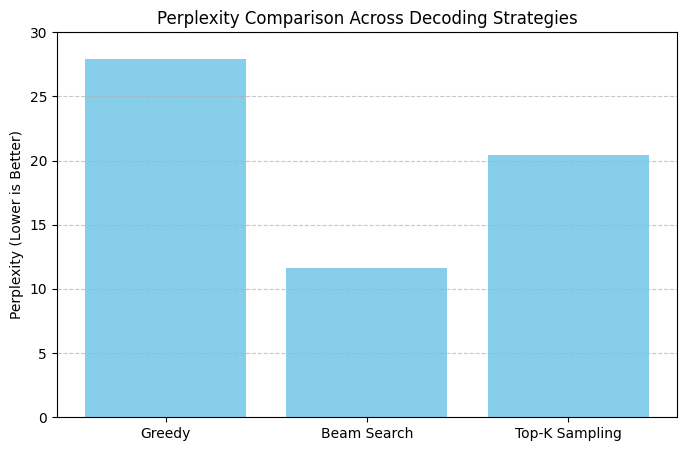

In [14]:
import matplotlib.pyplot as plt

perplexities = {
    "Greedy": 27.95,
    "Beam Search": 11.67,
    "Top-K Sampling": 20.40
}

plt.figure(figsize=(8, 5))
plt.bar(perplexities.keys(), perplexities.values(), color='skyblue')
plt.title("Perplexity Comparison Across Decoding Strategies")
plt.ylabel("Perplexity (Lower is Better)")
plt.ylim(0, 30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Bigram Language Modeling Summary (Moby-Dick):
- Here we built a bigram language model using 10 consecutive chapters (CHAPTER 10–19) from Moby-Dick.
- And performed preprocessing like lowercased all text, removed punctuation/symbols, and tokenized into 44,306 words.
- Then constructed a bigram frequency model using defaultdict(Counter) to capture word-to-word transitions.
- Generated 50-word sequences using three decoding strategies where Greedy Decoding (Perplexity ≈ 27.95) , Beam Search with width 3 (Perplexity ≈ 11.67) and Top-K Sampling with k=5 (Perplexity ≈ 20.67).
- Evaluated each method using perplexity scores, with beam search performing best in fluency and fit to the data.